# Experimentacion - AGREGANDO DATA EXTERNA

## Modelo - Ubicacion (Latitud y Longitud, Continente)

### Voy a experimentar con las caracterisiticas principales de los paises, como su ubicacion, su status, su capacidad de gasto. Todo ese tipo de atributos que lo encasillan en una etiqueta en particular. La zona donde se ubica un pais puede explicar varias cosas sobre el. Si pensamos en un pais ubicado en el hemisferio norte del mundo, es probable que demos con uno desarrollado. Mientras que si, por ejemplo, pensamos en un pais ubicado en Africa, es probable que su expectativa de vida sea menor a la media. Vamos a ver como esto se condice con los datos y el analisis de regresion.

### Importo todos los modulos, funciones y datasets que me son de ayuda para la experimentacion

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence as influence

def rmse(fitted, target):
    rmse = np.sqrt(mean_squared_error(target, fitted))
    return rmse

def adjusted_r2(p, fitted, target):
    n=len(target)
    return 1 - (1-r2_score(target, fitted)) * (n-1) / (n-p-1)

def standarized_residual_plot(predicted, actual):
    residuals = actual - predicted
    standarized_residuals = residuals/np.std(residuals)
    plt.scatter(predicted, standarized_residuals)
    plt.xlabel("Predicciones")
    plt.ylabel("Residuos standarizados")
    plt.hlines(0, xmin=min(predicted), xmax=max(predicted))
    plt.title("Residuos standarizados")
    return standarized_residuals

def ols_influence(lm):
    plt.figure(figsize=(30,30))
    sm.graphics.influence_plot(lm, alpha  = 0.05, criterion="cooks")
    plt.show()

    
def run_analysis(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    fitted = regr.predict(features)
    print(regr.summary())
    standarized_residuals = standarized_residual_plot(fitted, target)
    sns.set(rc={'figure.figsize':(15,10)})
    ols_influence(regr)
    #sm.qqplot(regr.resid)
    plt.figure()
    plt.hist(regr.resid)
    plt.show()
    return {
        'r2':r2_score(target, fitted),
        'rmse':rmse(fitted, target),
        'adjusted':adjusted_r2(p, fitted, target),
    }

# Me da los residuos estandarizados
def residuos(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    fitted = regr.predict(features)
    standarized_residuals = standarized_residual_plot(fitted, target)
    return np.array(standarized_residuals)


# Me da la distancia de Cook de cada pais
def cooksDist(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    inf = influence(regr)
    # cooks_distance is an attribute of incluence, here C, not sure about P (p-value maybe?)
    C, P = inf.cooks_distance
    return C, P

# Me da el Leverage de cada pais
def getLeverage(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    inf = influence(regr)
    leverage = inf.hat_matrix_diag
    return leverage


df_exp = pd.read_csv("expectativa_de_vida.csv")
df_coord = pd.read_csv("average-latitude-longitude-countries.csv")

### Armo el data set con la ubicacion en el mapa de cada pais (como se realiza en el archivo 'Mapa.ipynb')

In [2]:
paises = []
nombres1 = df_exp["Country"].tolist()
nombres2 = df_coord["Country"].tolist()

from difflib import SequenceMatcher

for i in range(len(nombres1)):
    n1 = nombres1[i]
    
    conSubstringsEnComun = []
    
    for j in range(len(nombres2)):
        n2 = nombres2[j]
        seq = SequenceMatcher(None, n1, n2)
        match = seq.find_longest_match(0,len(n1),0,len(n2))
        r = seq.ratio()
        
        if ((match[2] == len(n1)) or (match[2] == len(n2)) or (match[2] > 3 and r>0.6)):
            conSubstringsEnComun.append([r,n1,n2])
        
    conSubstringsEnComun.sort()
    conSubstringsEnComun.reverse()
    
    
    if (len(conSubstringsEnComun) > 0):
        paises.append([conSubstringsEnComun[0][1], conSubstringsEnComun[0][2]])
    else:
        paises.append(n1)

In [3]:
df = df_exp
latitudes = []
longitudes = []

for i in range(len(paises)):
    lat = df_coord[df_coord["Country"]==paises[i][1]]["Latitude"].values
    long = df_coord[df_coord["Country"]==paises[i][1]]["Longitude"].values
    if len(lat) > 0:
        lat = lat[0]
        long = long[0]
    else:
        lat = 0
        long = 0
    latitudes.append(lat)
    longitudes.append(long)

df["Latitude"] = latitudes
df["Longitude"] = longitudes

In [4]:
df['Status_Float'] = df['Status'].apply(lambda x: 0 if x=='Developing' else 1)


In [5]:
df[(df["Life expectancy"] > 80) & (df["Status"] == "Developing")]

,Unnamed: 0,Country,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status,Latitude,Longitude,Status_Float
30,30,Canada,81.68750,64.6250,2.0000,8.053333,4694.078971,28.846154,129.5000,55.86250,...,29382.907523,1.136405e+07,0.50625,0.43750,0.892188,15.87500,Developing,60.0,-95.00,0
57,59,Finland,80.71250,68.8750,0.0000,9.552667,2889.315470,NaN,2.8125,52.30000,...,25268.649758,3.493082e+06,0.90000,0.80625,0.872937,17.29375,Developing,64.0,26.00,0
58,60,France,82.21875,73.1250,2.9375,12.404667,3751.506574,51.250000,2661.6250,51.98125,...,26465.551381,2.758173e+07,0.62500,0.60000,0.870562,15.90000,Developing,46.0,2.00,0
64,66,Greece,81.21875,73.6250,0.1875,8.803333,1759.246820,88.937500,24.8750,58.68125,...,16454.235870,1.550208e+06,0.81250,0.73125,0.842313,15.93750,Developing,39.0,22.00,0
79,81,Israel,81.30000,59.5000,0.9375,2.497333,1467.535827,97.437500,138.9375,54.98750,...,18860.476016,2.786288e+04,1.14375,1.10000,0.873188,15.71250,Developing,31.5,34.75,0
130,137,Republic of Korea,80.48750,76.1875,2.1250,8.855333,0.000000,95.125000,3548.4375,23.24375,...,NaN,NaN,1.53750,1.01875,NaN,NaN,Developing,37.0,127.50,0


In [6]:
df[(df["Life expectancy"] < 75) & (df["Status"] == "Developed")]

,Unnamed: 0,Country,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status,Latitude,Longitude,Status_Float
24,24,Bulgaria,72.85000,125.5000,0.9375,10.865333,350.745204,94.5000,1530.3125,54.50000,...,4938.981821,5.290924e+06,2.13125,2.15625,0.754625,13.72500,Developed,43.00,25.0,1
72,74,Hungary,73.82500,147.0625,0.5625,11.427333,376.831080,NaN,2.0625,56.93125,...,8513.641831,1.604902e+06,1.91875,1.91250,0.804312,15.11875,Developed,47.00,20.0,1
90,92,Latvia,73.73125,161.8125,0.0000,8.864000,530.605192,88.9375,3.3125,51.30625,...,7951.824897,1.174563e+06,2.40625,2.43125,0.792500,15.56875,Developed,57.00,25.0,1
95,97,Lithuania,72.80625,117.2500,0.0000,12.632667,1015.753843,94.7500,14.9375,49.23125,...,9007.458623,1.926212e+06,2.93750,2.96875,0.806687,16.10000,Developed,56.00,24.0,1
132,139,Romania,74.05000,156.0625,2.8125,8.968667,426.536634,91.8125,1365.6875,52.25000,...,4258.940054,9.206346e+06,3.16875,3.50625,0.762625,13.92500,Developed,46.00,25.0,1
145,154,Slovakia,74.75000,118.0625,0.0000,10.473333,0.000000,98.5625,0.2500,51.81875,...,NaN,NaN,1.34375,1.42500,0.803312,14.35000,Developed,48.67,19.5,1


## Seteo correctamente el continente a un par de paises mal categorizados

In [7]:
df.loc[30, 'Status_Float'] = 1 #Cnada
df.loc[57, 'Status_Float'] = 1 #Finland
df.loc[58, 'Status_Float'] = 1 #France
df.loc[64, 'Status_Float'] = 1 #Greece
df.loc[79, 'Status_Float'] = 1 #Israel
df.loc[130, 'Status_Float'] = 1 #Republic of Korea
df.loc[24, 'Status_Float'] = 0 #Bulgaria
df.loc[72, 'Status_Float'] = 0 #Hungría
df.loc[95, 'Status_Float'] = 0 #Lithuania
df.loc[132, 'Status_Float'] = 0 #Rumanía
df.loc[145, 'Status_Float'] = 0 #Eslovaquia


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 25 columns):
Unnamed: 0                         183 non-null int64
Country                            183 non-null object
Life expectancy                    183 non-null float64
Adult Mortality                    183 non-null float64
infant deaths                      183 non-null float64
Alcohol                            182 non-null float64
percentage expenditure             183 non-null float64
Hepatitis B                        174 non-null float64
Measles                            183 non-null float64
BMI                                181 non-null float64
under-five deaths                  183 non-null float64
Polio                              183 non-null float64
Total expenditure                  181 non-null float64
Diphtheria                         183 non-null float64
HIV/AIDS                           183 non-null float64
GDP                                158 non-null float64
Po

### Ahora agrego la zona donde se encuentra cada Estado

In [9]:
df_zona = pd.read_csv("country-and-continent-codes-list.csv")

In [10]:
df_zona.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 6 columns):
Continent_Name               262 non-null object
Continent_Code               219 non-null object
Country_Name                 262 non-null object
Two_Letter_Country_Code      261 non-null object
Three_Letter_Country_Code    258 non-null object
Country_Number               258 non-null float64
dtypes: float64(1), object(5)
memory usage: 12.4+ KB


### Equivalencia entre paises

In [11]:
paises = []
nombres1 = df["Country"].tolist()
nombres2 = df_zona["Country_Name"].tolist()

for i in range(len(nombres1)):
    n1 = nombres1[i]
    
    conSubstringsEnComun = []
    
    for j in range(len(nombres2)):
        n2 = nombres2[j]
        seq = SequenceMatcher(None, n1, n2)
        match = seq.find_longest_match(0,len(n1),0,len(n2))
        
        """
        if ((match[2] == len(n1)) or (match[2] == len(n2))):
            r = seq.ratio()
            conSubstringsEnComun.append([r,n1,n2])
        """
        r = seq.ratio()
        
        if ((match[2] == len(n1)) or (match[2] == len(n2)) or (match[2] > 3 and r>0.6)):
            conSubstringsEnComun.append([r,n1,n2])
        
    conSubstringsEnComun.sort()
    conSubstringsEnComun.reverse()
    
    
    if (len(conSubstringsEnComun) > 0):
        paises.append([conSubstringsEnComun[0][1], conSubstringsEnComun[0][2]])
    else:
        paises.append(n1)

In [12]:
df_new = df
zonas = []

for i in range(len(paises)):
    zone = df_zona[df_zona["Country_Name"]==paises[i][1]]["Continent_Name"].values
    if len(zone) > 0:
        zone = zone[0]
    else:
        zone = 'null'
    zonas.append(zone)

df_new["Continente"] = zonas

In [13]:
df_new["Continente"]

0               Asia
1             Europe
2             Africa
3               Asia
4      North America
5      South America
6               Asia
7            Oceania
8             Europe
9             Europe
10     North America
11              Asia
12              Asia
13     North America
14            Europe
15            Europe
16     North America
17            Africa
18              Asia
19              null
20            Europe
21            Africa
22     South America
23              Asia
24            Europe
25            Africa
26            Africa
27              null
28              Asia
29            Africa
           ...      
153           Africa
154    South America
155           Africa
156           Europe
157           Europe
158             Asia
159             Asia
160             Asia
161           Europe
162             Asia
163           Africa
164          Oceania
165    North America
166           Africa
167           Europe
168             Asia
169          

### Veo aquellos paises que quedaron sin zona y los completamos

In [14]:
df_new[df_new["Continente"] == 'null']

,Unnamed: 0,Country,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status,Latitude,Longitude,Status_Float,Continente
19,19,Bolivia (Plurinational State of),67.70625,177.5000,10.7500,3.212000,0.000000,82.875000,7.6250,44.81875,...,NaN,1.30000,1.1875,0.633750,13.9625,Developing,-17.0,-65.0,0,null
27,27,Cabo Verde,72.51875,116.1875,0.0000,3.448000,188.632987,80.642857,0.1250,24.37500,...,292600.25,8.01250,7.9750,0.570000,12.2000,Developing,16.0,-24.0,0,null
42,43,Czechia,76.76875,71.8125,0.0000,13.026000,0.000000,97.285714,22.9375,55.71250,...,NaN,1.99375,2.0625,NaN,NaN,Developed,0.0,0.0,1,null
88,90,Kyrgyzstan,69.08125,173.6875,3.7500,2.267333,0.000000,85.562500,1156.6250,35.11250,...,NaN,3.35625,3.4125,0.622063,12.3375,Developing,41.0,75.0,0,null
179,189,Viet Nam,74.77500,126.5625,29.1875,3.087333,0.000000,87.538462,4232.9375,11.18750,...,NaN,14.92500,15.6250,0.627063,11.5125,Developing,16.0,106.0,0,null


### Les asigno sus respectivos continentes

In [15]:
df_new.loc[19, 'Continente'] = 'South America' #Bolivia
df_new.loc[27, 'Continente'] = 'Africa' #Cabo Verde
df_new.loc[42, 'Continente'] = 'Europe' #Czechia
df_new.loc[88, 'Continente'] = 'Asia' # Kyrgyzstan
df_new.loc[179, 'Continente'] = 'Asia' #Viet Nam

In [16]:
df_new[df_new['Country'] == 'Bolivia (Plurinational State of)']['Continente'] 

19    South America
Name: Continente, dtype: object

## Convierto en variables dummie 

In [17]:
dummies = pd.get_dummies(df_new.Continente)
print(dummies)
df_new = df_new.join(dummies)


     Africa  Asia  Europe  North America  Oceania  South America
0         0     1       0              0        0              0
1         0     0       1              0        0              0
2         1     0       0              0        0              0
3         0     1       0              0        0              0
4         0     0       0              1        0              0
5         0     0       0              0        0              1
6         0     1       0              0        0              0
7         0     0       0              0        1              0
8         0     0       1              0        0              0
9         0     0       1              0        0              0
10        0     0       0              1        0              0
11        0     1       0              0        0              0
12        0     1       0              0        0              0
13        0     0       0              1        0              0
14        0     0       1

### Sabiendo las coordenadas de cada pais, analizamos como estas infieren en su expectativa de vida

VIF for Latitude 1.0437650861009335
VIF for Longitude 1.0437650861009335
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     27.76
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           3.12e-11
Time:                        17:00:32   Log-Likelihood:                -640.41
No. Observations:                 183   AIC:                             1287.
Df Residuals:                     180   BIC:                             1296.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

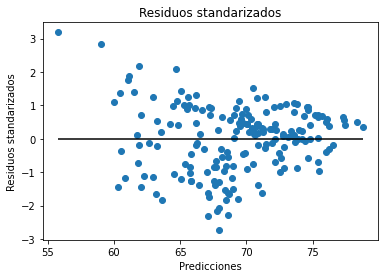

<Figure size 2160x2160 with 0 Axes>

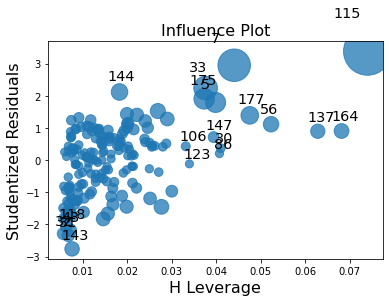

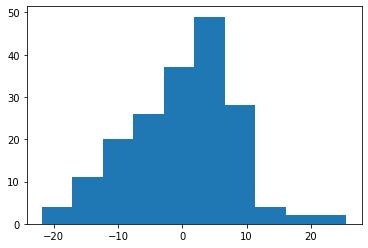

{'r2': 0.235703390469284,
 'rmse': 8.009178403974595,
 'adjusted': 0.22721120591894284}

In [18]:
run_analysis(['Latitude', 'Longitude'], df_new)

### Por lo pronto no hay un valor considerable en el ajuste. Y si anadimos su zona? Nos proveera mas informacion esto?

### Agregamos el continente de un pais

VIF for Africa 1.0
VIF for Asia 1.0
VIF for Europe 1.0
VIF for North America 1.0
VIF for Oceania 1.0
VIF for South America 1.0
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     41.34
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           4.69e-28
Time:                        17:00:32   Log-Likelihood:                -594.21
No. Observations:                 183   AIC:                             1200.
Df Residuals:                     177   BIC:                             1220.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----

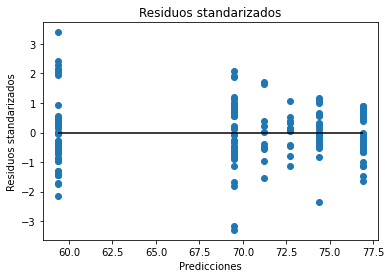

<Figure size 2160x2160 with 0 Axes>

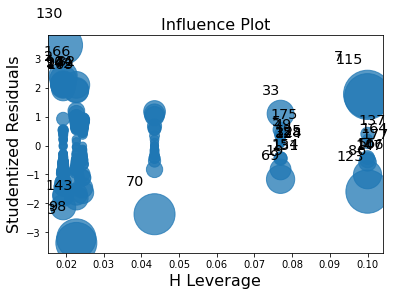

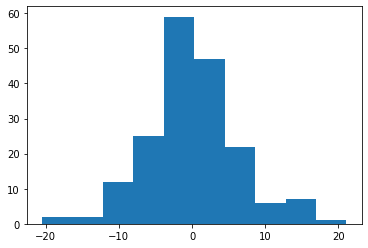

{'r2': 0.5387026838887314,
 'rmse': 6.22225012433972,
 'adjusted': 0.5229766390213019}

In [19]:
run_analysis(['Africa', 'Asia', 'Europe', 'North America', 'Oceania',
       'South America'], df_new)

### Ahora si, mejora considerablemente. Que pasa si agregamos el status de un pais tambien?

VIF for Africa 1.0010241044550607
VIF for Asia 1.0108927473856457
VIF for Europe 1.6870991548734227
VIF for North America 1.0370458655048054
VIF for Oceania 1.021301372665263
VIF for South America 1.0
VIF for Status_Float 1.4404616761345874
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     53.89
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           2.37e-37
Time:                        17:00:33   Log-Likelihood:                -569.59
No. Observations:                 183   AIC:                             1153.
Df Residuals:                     176   BIC:                             1176.
Df Model:                           6                                         
Covariance Type:            nonrobust           

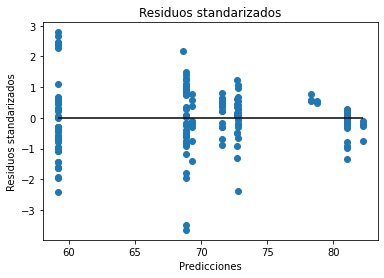

<Figure size 2160x2160 with 0 Axes>

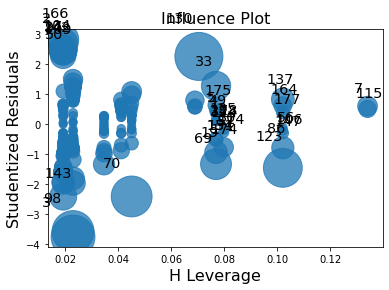

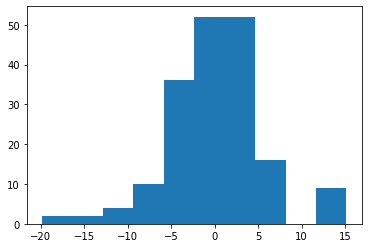

{'r2': 0.6475550750266479,
 'rmse': 5.43879427594664,
 'adjusted': 0.6334572780277138}

In [20]:
run_analysis(['Africa', 'Asia', 'Europe', 'North America', 'Oceania',
       'South America', 'Status_Float'], df_new)

## Calculo residuos

VIF for Africa 1.0010241044550607
VIF for Asia 1.0108927473856457
VIF for Europe 1.6870991548734227
VIF for North America 1.0370458655048054
VIF for Oceania 1.021301372665263
VIF for South America 1.0
VIF for Status_Float 1.4404616761345874
VIF for Africa 1.0
VIF for Asia 1.0
VIF for Europe 1.0
VIF for North America 1.0
VIF for Oceania 1.0
VIF for South America 1.0


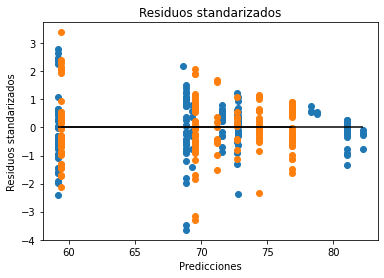

In [21]:
residuos_con_status = residuos(['Africa', 'Asia', 'Europe', 'North America', 'Oceania',
       'South America', 'Status_Float'], df_new)
residuos_sin_status = residuos(['Africa', 'Asia', 'Europe', 'North America', 'Oceania',
       'South America'], df_new)

/home/sebasbocaccio/anaconda3/envs/tp2/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


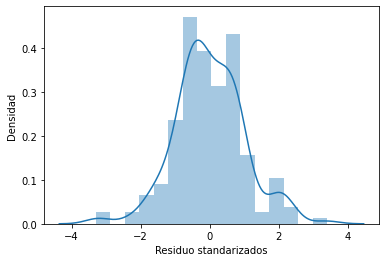

In [22]:
plot = sns.distplot(residuos_sin_status)
plot.set(xlabel='Residuo standarizados', ylabel='Densidad')
fig = plot.get_figure()
fig.savefig('residuos_sin_status') 

/home/sebasbocaccio/anaconda3/envs/tp2/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


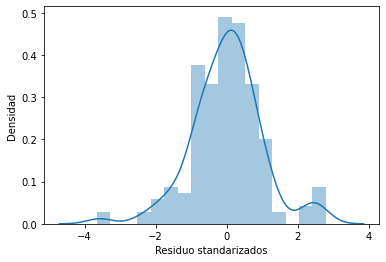

In [23]:
plot = sns.distplot(residuos_con_status)
plot.set(xlabel='Residuo standarizados', ylabel='Densidad')
fig = plot.get_figure()
fig.savefig('residuos_con_status') 

### Genera una mejora. Finalizemos agregando el gasto por pais, esto seguro nos dara un mayor contexto. Mezclando no solo la geografia de los paises sino tambien las finanzas, estos atributos van de la mano con el 'Status' de un pais. Estaran tan correlacionados con la zona como este ultimo?

### Saco los paises con percentage expenditure que no consideramos validos

In [24]:
df_new = df_new[df_new["percentage expenditure"] <= 1000]

In [25]:
df_new = df_new[df_new['percentage expenditure'].notna()]
df_new[f'Normalizado_Gasto'] = (df_new['percentage expenditure']-np.mean(df_new['percentage expenditure']))/np.std(df_new['percentage expenditure'])

VIF for Africa 1.0564233444254434
VIF for Asia 1.0162468982277046
VIF for Europe 1.0429697010184342
VIF for North America 1.033920281627105
VIF for Oceania 1.001497630060439
VIF for South America 1.052051896962406
VIF for Normalizado_Gasto 1.203109752321532
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     28.72
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           2.02e-22
Time:                        17:10:13   Log-Likelihood:                -476.11
No. Observations:                 151   AIC:                             966.2
Df Residuals:                     144   BIC:                             987.3
Df Model:                           6                                         
Covariance Type:            non

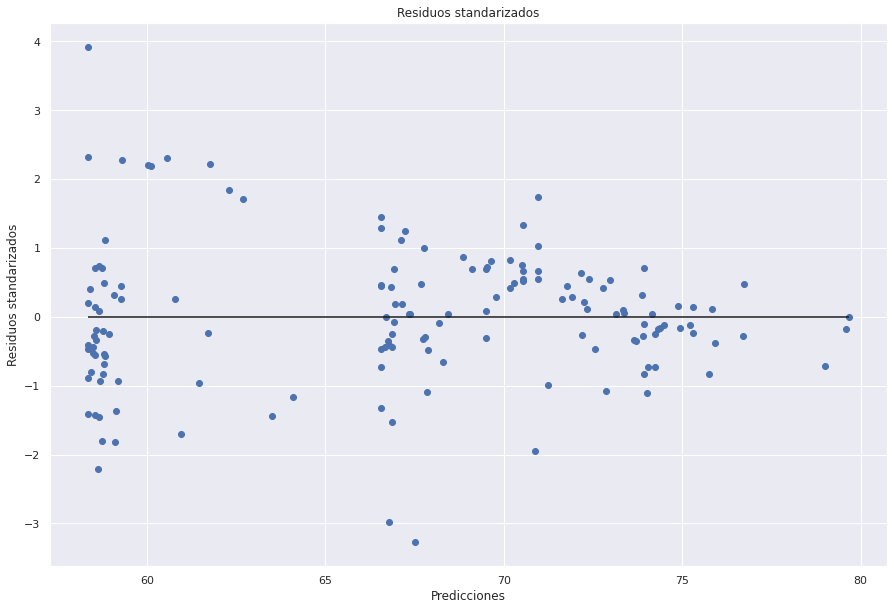

<Figure size 2160x2160 with 0 Axes>

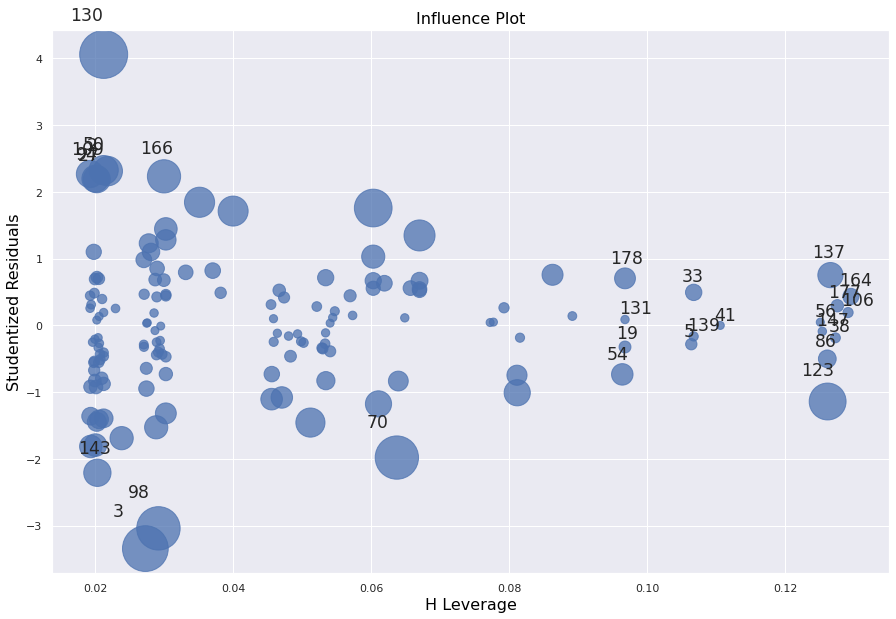

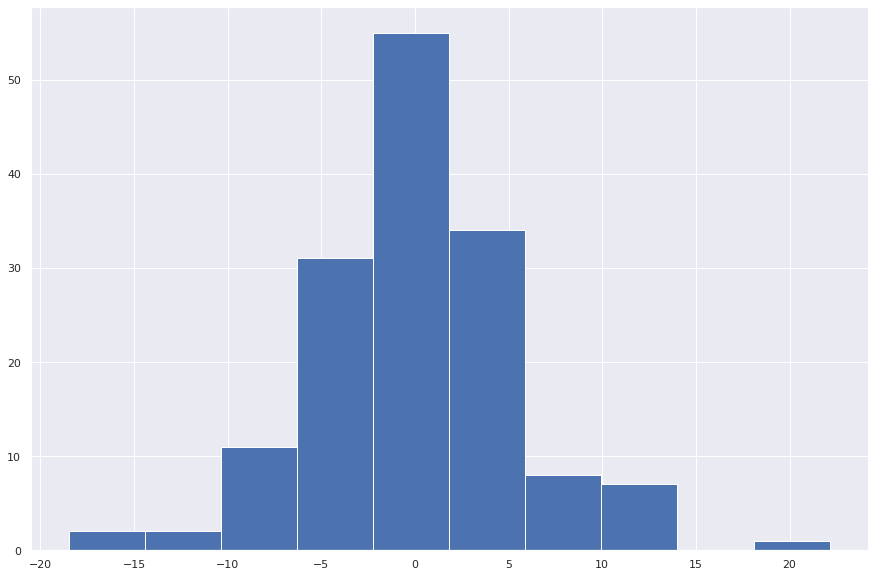

{'r2': 0.5447908636294116,
 'rmse': 5.663708596242874,
 'adjusted': 0.5225078989119702}

In [49]:
run_analysis(['Africa', 'Asia', 'Europe', 'North America', 'Oceania',
       'South America', 'Normalizado_Gasto'], df_new)


VIF for Africa 1.0564233444254434
VIF for Asia 1.0162468982277046
VIF for Europe 1.0429697010184342
VIF for North America 1.033920281627105
VIF for Oceania 1.001497630060439
VIF for South America 1.052051896962406
VIF for Normalizado_Gasto 1.203109752321532


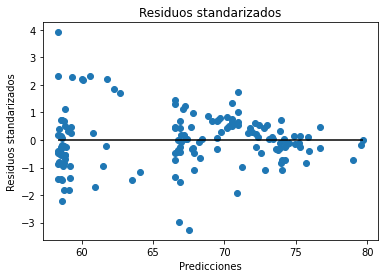

In [27]:
residuos_con_pe = residuos(['Africa', 'Asia', 'Europe', 'North America', 'Oceania',
       'South America', 'Normalizado_Gasto'], df_new)

/home/sebasbocaccio/anaconda3/envs/tp2/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


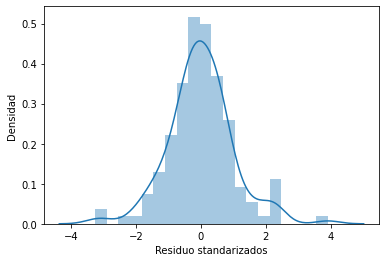

In [28]:
plot = sns.distplot(residuos_con_pe)
plot.set(xlabel='Residuo standarizados', ylabel='Densidad')
fig = plot.get_figure()
fig.savefig('residuos_con_gasto') 

### Subio el ajuste, pero no tanto. Sera porque la zona de un pais y su gasto estan demasiado correlacionados?

## Saco outliers

In [29]:
# Empezamos con 
display(df_new)

,Unnamed: 0,Country,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Longitude,Status_Float,Continente,Africa,Asia,Europe,North America,Oceania,South America,Normalizado_Gasto
0,0,Afghanistan,58.19375,269.0625,78.2500,0.014375,34.960110,64.562500,2362.2500,15.51875,...,65.00,0,Asia,0,1,0,0,0,0,-0.710578
1,1,Albania,75.15625,45.0625,0.6875,4.848750,193.259091,98.000000,53.3750,49.06875,...,20.00,0,Europe,0,0,1,0,0,0,0.006119
2,2,Algeria,73.61875,108.1875,20.3125,0.406667,236.185241,78.000000,1943.8750,48.74375,...,3.00,0,Africa,1,0,0,0,0,0,0.200466
3,3,Angola,49.01875,328.5625,83.7500,5.740667,102.100268,70.222222,3561.3125,18.01875,...,18.50,0,Asia,0,1,0,0,0,0,-0.406602
5,5,Argentina,75.15625,106.0000,10.1250,7.966667,773.038981,81.285714,2.0000,54.98125,...,-64.00,0,South America,0,0,0,0,0,1,2.631063
6,6,Armenia,73.40000,117.3750,1.0000,3.702667,131.007419,87.562500,274.2500,44.70625,...,45.00,0,Asia,0,1,0,0,0,0,-0.275725
9,9,Azerbaijan,70.73125,115.1875,6.0625,0.992000,131.148747,59.214286,598.1875,43.84375,...,47.50,0,Europe,0,0,1,0,0,0,-0.275085
10,10,Bahamas,74.28750,152.0625,0.0000,10.271333,0.000000,83.600000,0.0000,52.88125,...,-76.00,0,North America,0,0,0,1,0,0,-0.868859
11,11,Bahrain,75.72500,65.3750,0.0000,1.934667,602.087140,98.125000,6.6875,51.65625,...,50.55,0,Asia,0,1,0,0,0,0,1.857081
12,12,Bangladesh,69.30000,141.3750,153.6250,0.010000,32.320972,77.615385,4649.9375,12.87500,...,90.00,0,Asia,0,1,0,0,0,0,-0.722526


### Residuos

VIF for Africa 1.0564233444254434
VIF for Asia 1.0162468982277046
VIF for Europe 1.0429697010184342
VIF for North America 1.033920281627105
VIF for Oceania 1.001497630060439
VIF for South America 1.052051896962406
VIF for Normalizado_Gasto 1.203109752321532


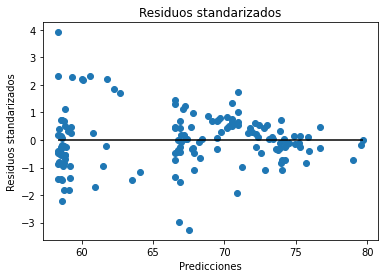

In [30]:
residuos_out = residuos(['Africa', 'Asia', 'Europe', 'North America', 'Oceania',
       'South America', 'Normalizado_Gasto'], df_new)

In [31]:
df_new_out = df_new.assign(residuos_out = residuos_out)
print()

#### Veamos cuales quedan afuera

In [32]:
display(df_new_out[(df_new_out["residuos_out"]**2)**0.5 > 2])

,Unnamed: 0,Country,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Status_Float,Continente,Africa,Asia,Europe,North America,Oceania,South America,Normalizado_Gasto,residuos_out
2,2,Algeria,73.61875,108.1875,20.3125,0.406667,236.185241,78.000000,1943.8750,48.74375,...,0,Africa,1,0,0,0,0,0,0.200466,2.307468
3,3,Angola,49.01875,328.5625,83.7500,5.740667,102.100268,70.222222,3561.3125,18.01875,...,0,Asia,0,1,0,0,0,0,-0.406602,-3.263362
27,27,Cabo Verde,72.51875,116.1875,0.0000,3.448000,188.632987,80.642857,0.1250,24.37500,...,0,Africa,1,0,0,0,0,0,-0.014826,2.191576
50,52,Egypt,71.50000,170.6250,56.2500,0.188667,0.000000,96.687500,1069.2500,49.26250,...,0,Africa,1,0,0,0,0,0,-0.868859,2.322415
94,96,Libya,72.48750,139.6875,2.1875,0.010000,180.074989,96.312500,547.3125,54.83750,...,0,Africa,1,0,0,0,0,0,-0.053572,2.200155
98,100,Malawi,49.89375,424.4375,37.1250,0.919333,25.849706,89.571429,7559.4375,16.78125,...,0,Asia,0,1,0,0,0,0,-0.751825,-2.983271
109,113,Morocco,72.15625,95.1875,21.3750,0.518667,102.989658,87.250000,2593.0000,48.61875,...,0,Africa,1,0,0,0,0,0,-0.402575,2.268642
130,137,Republic of Korea,80.48750,76.1875,2.1250,8.855333,0.000000,95.125000,3548.4375,23.24375,...,1,Africa,1,0,0,0,0,0,-0.868859,3.909272
143,152,Sierra Leone,46.11250,357.8125,27.5625,3.154667,29.105579,83.444444,673.8750,18.30625,...,0,Africa,1,0,0,0,0,0,-0.737084,-2.208014
166,175,Tunisia,74.35625,18.7500,3.2500,1.310667,366.741260,96.750000,33.1875,48.25625,...,0,Africa,1,0,0,0,0,0,0.791556,2.222634


##### Los sacamos

In [33]:
df_new_out = df_new_out[(df_new_out["residuos_out"]**2)**0.5 <= 2]

### Distancia de Cook

In [34]:
cook_out, p_out = cooksDist(['Africa', 'Asia', 'Europe', 'North America', 'Oceania',
       'South America', 'Normalizado_Gasto'], df_new_out)

VIF for Africa 1.0550521132834778
VIF for Asia 1.0132009745882444
VIF for Europe 1.043973715050144
VIF for North America 1.0347128502953988
VIF for Oceania 1.0015326231267008
VIF for South America 1.053268122202254
VIF for Normalizado_Gasto 1.2011802940337586


In [35]:
df_new_out = df_new_out.assign(cook_out = cook_out)
display(df_new_out.sort_values('cook_out'))

,Unnamed: 0,Country,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Continente,Africa,Asia,Europe,North America,Oceania,South America,Normalizado_Gasto,residuos_out,cook_out
163,172,Togo,56.66250,311.3125,14.1875,0.947333,23.705604,76.625000,532.5000,17.99375,...,Africa,1,0,0,0,0,0,-0.761532,-0.336383,3.062056e-07
176,186,Uzbekistan,68.03125,184.8125,21.9375,1.608667,44.373450,95.642857,208.4375,34.80625,...,Asia,0,1,0,0,0,0,-0.667959,0.188624,7.809735e-07
131,138,Republic of Moldova,69.98125,210.3125,1.0000,9.545333,0.000000,95.000000,390.8750,43.90625,...,South America,0,0,0,0,0,1,-0.868859,0.086600,6.143703e-06
117,122,Niger,56.98125,232.4375,52.8125,0.091333,19.099369,60.571429,15467.1250,16.36250,...,Africa,1,0,0,0,0,0,-0.782387,-0.272516,1.752986e-05
85,87,Kenya,57.48125,348.5625,65.8750,1.602000,61.655464,74.571429,2643.8750,15.56250,...,Africa,1,0,0,0,0,0,-0.589715,-0.254332,3.706768e-05
13,13,Barbados,74.35625,77.6250,0.0000,8.206667,389.076995,84.066667,0.0000,45.97500,...,North America,0,0,0,1,0,0,0.892681,0.034750,3.939870e-05
173,183,United Republic of Tanzania,56.00625,304.4375,95.2500,3.582667,0.000000,73.500000,3348.5625,17.31875,...,Africa,1,0,0,0,0,0,-0.868859,-0.413205,4.624174e-05
22,22,Brazil,73.38125,150.6875,68.2500,7.213333,390.695595,96.187500,95.3750,47.06250,...,South America,0,0,0,0,0,1,0.900009,0.043368,5.540177e-05
38,39,Costa Rica,78.59375,69.3750,1.0000,3.924667,972.359150,79.312500,0.1875,46.72500,...,North America,0,0,0,1,0,0,3.533482,-0.177835,5.887391e-05
56,58,Fiji,68.71250,125.0000,0.0000,1.462667,139.156838,98.875000,50.0000,50.56250,...,Oceania,0,0,0,0,1,0,-0.238829,0.046710,6.764681e-05


In [36]:
display(df_new_out[df_new_out["cook_out"] > 0.05])

,Unnamed: 0,Country,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Continente,Africa,Asia,Europe,North America,Oceania,South America,Normalizado_Gasto,residuos_out,cook_out
70,72,Haiti,59.86875,168.3125,17.0,5.486,36.1292,40.666667,71.9375,39.275,...,North America,0,0,0,1,0,0,-0.705285,-1.941835,0.065586


In [37]:
df_new_out = df_new_out[df_new_out["cook_out"] < 0.05]

### Leverage

In [38]:
leverage_out = getLeverage(['Africa', 'Asia', 'Europe', 'North America', 'Oceania',
       'South America', 'Normalizado_Gasto',], df_new_out)

VIF for Africa 1.0557183086482496
VIF for Asia 1.0133607219177592
VIF for Europe 1.0445058487574788
VIF for North America 1.0431291066596864
VIF for Oceania 1.0015511696703674
VIF for South America 1.0539127291752595
VIF for Normalizado_Gasto 1.211318861908311


In [39]:
df_new_out = df_new_out.assign(leverage_out = leverage_out)

In [40]:
display(df_new_out[df_new_out["leverage_out"] > 0.11])

,Unnamed: 0,Country,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Africa,Asia,Europe,North America,Oceania,South America,Normalizado_Gasto,residuos_out,cook_out,leverage_out
38,39,Costa Rica,78.59375,69.3750,1.000,3.924667,972.359150,79.3125,0.1875,46.72500,...,0,0,0,1,0,0,3.533482,-0.177835,0.000059,0.129563
41,42,Cyprus,79.67500,54.1250,0.000,10.260667,932.667390,92.6250,1.9375,53.16250,...,0,0,1,0,0,0,3.353778,0.000083,0.000539,0.112893
56,58,Fiji,68.71250,125.0000,0.000,1.462667,139.156838,98.8750,50.0000,50.56250,...,0,0,0,0,1,0,-0.238829,0.046710,0.000068,0.125060
86,88,Kiribati,65.15000,129.4375,0.000,0.440667,77.126103,75.1875,0.0000,69.43125,...,0,0,0,0,1,0,-0.519672,-0.480119,0.009194,0.126108
106,109,Micronesia (Federated States of),68.20000,154.0625,0.000,2.145333,0.000000,75.4375,8.7500,65.15000,...,0,0,0,0,1,0,-0.868859,0.185438,0.000900,0.129226
123,130,Papua New Guinea,61.68125,266.5625,10.625,0.580667,75.370482,57.0000,2349.8750,40.78750,...,0,0,0,0,1,0,-0.527620,-1.089679,0.045657,0.126156
137,145,Samoa,73.61875,133.5625,0.000,2.704000,254.597018,54.9375,0.5625,62.90625,...,0,0,0,0,1,0,0.283825,0.722821,0.020648,0.126577
139,148,Saudi Arabia,73.46875,52.1250,8.625,0.074667,838.506400,96.8125,759.3125,55.31250,...,0,1,0,0,0,0,2.927466,-0.159395,0.001185,0.110069
147,156,Solomon Islands,67.71250,140.0625,0.000,0.800667,112.027416,78.6250,0.0000,39.17500,...,0,0,0,0,1,0,-0.361657,-0.085166,0.000331,0.125358
164,173,Tonga,72.53125,129.6250,0.000,1.167333,323.809343,75.5000,0.2500,62.94375,...,0,0,0,0,1,0,0.597183,0.416804,0.007846,0.129648


In [41]:
df_new_out = df_new_out[df_new_out["leverage_out"] < 0.11]

In [42]:
pd.concat([df_new_out,df_new]).drop_duplicates(keep=False)['Country'].tolist()


/home/sebasbocaccio/anaconda3/envs/tp2/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


['Afghanistan',
 'Albania',
 'Argentina',
 'Armenia',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia (Plurinational State of)',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo',
 'Cuba',
 'Czechia',
 "Côte d'Ivoire",
 "Democratic People's Republic of Korea",
 'Democratic Republic of the Congo',
 'Djibouti',
 'Dominican Republic',
 'Ecuador',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Ethiopia',
 'Gabon',
 'Gambia',
 'Georgia',
 'Ghana',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Honduras',
 'Hungary',
 'India',
 'Indonesia',
 'Iran (Islamic Republic of)',
 'Iraq',
 'Jamaica',
 'Jordan',
 'Kazakhstan',
 'Kenya',
 'Kyrgyzstan',
 "Lao People's Democratic Republic",
 'Latvia',
 'Lebanon',
 'Lesotho',
 'Liberia',


### Veo datos sobrevivientes

In [43]:
display(df_new_out)

,Unnamed: 0,Country,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Africa,Asia,Europe,North America,Oceania,South America,Normalizado_Gasto,residuos_out,cook_out,leverage_out
0,0,Afghanistan,58.19375,269.0625,78.2500,0.014375,34.960110,64.562500,2362.2500,15.51875,...,0,1,0,0,0,0,-0.710578,-1.532807,2.206941e-02,0.030598
1,1,Albania,75.15625,45.0625,0.6875,4.848750,193.259091,98.000000,53.3750,49.06875,...,0,0,1,0,0,0,0.006119,0.420177,1.867758e-03,0.047428
5,5,Argentina,75.15625,106.0000,10.1250,7.966667,773.038981,81.285714,2.0000,54.98125,...,0,0,0,0,0,1,2.631063,-0.273021,1.047362e-03,0.107414
6,6,Armenia,73.40000,117.3750,1.0000,3.702667,131.007419,87.562500,274.2500,44.70625,...,0,1,0,0,0,0,-0.275725,0.993844,4.517309e-03,0.028602
9,9,Azerbaijan,70.73125,115.1875,6.0625,0.992000,131.148747,59.214286,598.1875,43.84375,...,0,0,1,0,0,0,-0.275085,-0.258806,1.085554e-03,0.050350
10,10,Bahamas,74.28750,152.0625,0.0000,10.271333,0.000000,83.600000,0.0000,52.88125,...,0,0,0,1,0,0,-0.868859,0.663490,6.343916e-03,0.071909
11,11,Bahrain,75.72500,65.3750,0.0000,1.934667,602.087140,98.125000,6.6875,51.65625,...,0,1,0,0,0,0,1.857081,0.628400,4.839732e-03,0.064006
12,12,Bangladesh,69.30000,141.3750,153.6250,0.010000,32.320972,77.615385,4649.9375,12.87500,...,0,1,0,0,0,0,-0.722526,0.432490,3.931889e-04,0.030696
13,13,Barbados,74.35625,77.6250,0.0000,8.206667,389.076995,84.066667,0.0000,45.97500,...,0,0,0,1,0,0,0.892681,0.034750,3.939870e-05,0.056589
14,14,Belarus,69.90625,218.7500,0.5625,13.497333,329.046455,88.937500,24.8125,54.74375,...,0,0,1,0,0,0,0.620894,-0.730443,5.932160e-03,0.045585


### Rehago analisis

VIF for Africa 1.0741576714352679
VIF for Asia 1.0353115807275728
VIF for Europe 1.0297248480477235
VIF for North America 1.0245607075430792
VIF for Oceania nan
VIF for South America 1.0717545552503607
VIF for Normalizado_Gasto 1.233571288373055


/home/sebasbocaccio/anaconda3/envs/tp2/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     73.98
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           2.06e-35
Time:                        17:00:37   Log-Likelihood:                -364.94
No. Observations:                 129   AIC:                             741.9
Df Residuals:                     123   BIC:                             759.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         57.4975      0.343    167.393      0.0

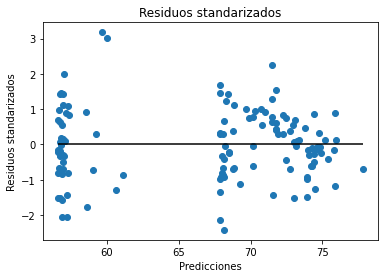

<Figure size 2160x2160 with 0 Axes>

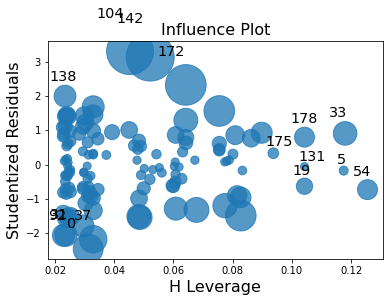

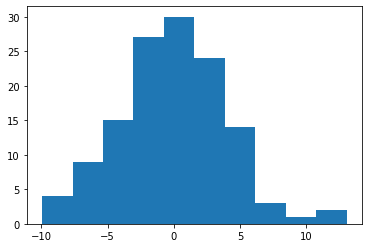

{'r2': 0.7504476495959507,
 'rmse': 4.096095663894982,
 'adjusted': 0.7360107367626585}

In [44]:
run_analysis(['Africa', 'Asia', 'Europe', 'North America', 'Oceania',
       'South America', 'Normalizado_Gasto'], df_new_out)

VIF for Africa 1.0741576714352679
VIF for Asia 1.0353115807275728
VIF for Europe 1.0297248480477235
VIF for North America 1.0245607075430792
VIF for Oceania nan
VIF for South America 1.0717545552503607
VIF for Normalizado_Gasto 1.233571288373055


/home/sebasbocaccio/anaconda3/envs/tp2/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


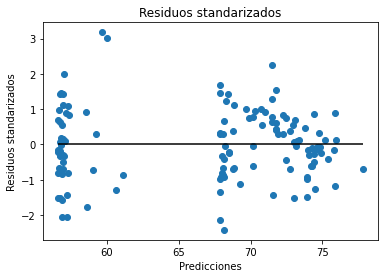

In [45]:
residuos_sin_outliers = residuos(['Africa', 'Asia', 'Europe', 'North America', 'Oceania',
       'South America', 'Normalizado_Gasto'], df_new_out)

/home/sebasbocaccio/anaconda3/envs/tp2/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


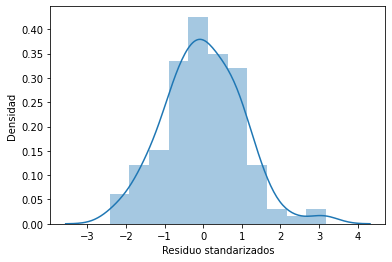

In [46]:
plot = sns.distplot(residuos_sin_outliers)
plot.set(xlabel='Residuo standarizados', ylabel='Densidad')
fig = plot.get_figure()
fig.savefig('residuos_sin_outliers') 

### Grafico regresion

### Dio muchos mejores valores